In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
pd.set_option('display.max_columns', None)
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('.')
sys.path.append('./scripts')
from competing_methods_local import *
from simulations_util import *
from util import  apply_splitting_strategy
from sklearn.preprocessing import StandardScaler
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 2.0

/accounts/projects/binyu/zhongyuan_liang/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Feature Ranking

In [2]:
methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
    'MDI',
    'LIME_RF',
    'TreeSHAP_RF',
]
color_map = {
    'LIME_RF': '#71BEB7',
    'TreeSHAP_RF': 'orange',
    'MDI': '#9B5DFF',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black'
}

regression_data_name = {
    "openml_361260": "Miami Housing",
    "openml_361259": "Puma Robot",
    "openml_361253": "Wave Energy",
    "openml_361254": "SARCOS",
    "openml_361242": "Super Conductivity",
    "openml_361243": "Geographic Origin of Music"
}

regression_feature_values = {
    "openml_361260": 15,
    "openml_361259": 32,
    "openml_361253": 48,
    "openml_361254": 21,
    "openml_361242": 81,
    "openml_361243": 72
}


classification_data_name = {
    "openml_43": "Spam",
    "openml_361062": "Pol",
    "openml_361071": "Jannis",
    "openml_9978": "Ozone",
    "openml_361069": "Higgs",
    "openml_361063": "House 16H"
}

classification_feature_values = {
    "openml_43": 57,
    "openml_361062": 26,
    "openml_361071": 54,
    "openml_9978": 47,
    "openml_361069": 24,
    "openml_361063": 16
}

methods_name = {
    'LIME_RF': 'LIME',
    'MDI': 'bLoTLA',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA',
}

data_generator_label_map = {
    'linear': 'Linear',
    'interaction': 'Interaction',
    'linear_lss': 'Linear + LSS',
    'logistic_linear': 'Logistic',
    'logistic_interaction': 'Logistic Interaction',
    'logistic_linear_lss': 'Logistic + LSS'

}

In [3]:
combined_df = pd.DataFrame()
datasets = ["openml_361254"]
for dgp in ["linear", "interaction", "linear_lss"]:
    for data in datasets:
        ablation_directory = f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_regression_{data}_{dgp}/{data}_{dgp}/varying_heritability_sample_row_n"
        feature_seeds = [1,2,3,4,5,6,7,8,9,10]
        sample_seeds = [1,2,3]
        for sample_seed in sample_seeds:
            for feature_seed in feature_seeds:
                df = pd.read_csv(os.path.join(ablation_directory, f"seed_{feature_seed}_{sample_seed}/results.csv"))
                df["data"] = data
                df["dgp"] = dgp
                combined_df = pd.concat([combined_df, df], ignore_index=True)
df_regression = combined_df.groupby(['train_size', 'heritability', 'dgp', 'fi', 'data'])[["auroc_train", "auroc_test"]].mean().reset_index()

In [ ]:
combined_df = pd.DataFrame()
datasets = ["openml_361070"]
for dgp in ["logistic_linear", "logistic_interaction", "logistic_linear_lss"]:
    for data in datasets:
        ablation_directory = f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_regression_{data}_{dgp}/{data}_{dgp}/varying_heritability_sample_row_n"
        feature_seeds = [1,2,3,4,5,6,7,8,9,10]
        sample_seeds = [1,2,3]
        for sample_seed in sample_seeds:
            for feature_seed in feature_seeds:
                df = pd.read_csv(os.path.join(ablation_directory, f"seed_{feature_seed}_{sample_seed}/results.csv"))
                df["data"] = data
                df["dgp"] = dgp
                combined_df = pd.concat([combined_df, df], ignore_index=True)
df_classification = combined_df.groupby(['train_size', 'frac_label_corruption', 'dgp', 'fi', 'data'])[["auroc_train", "auroc_test"]].mean().reset_index()

/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


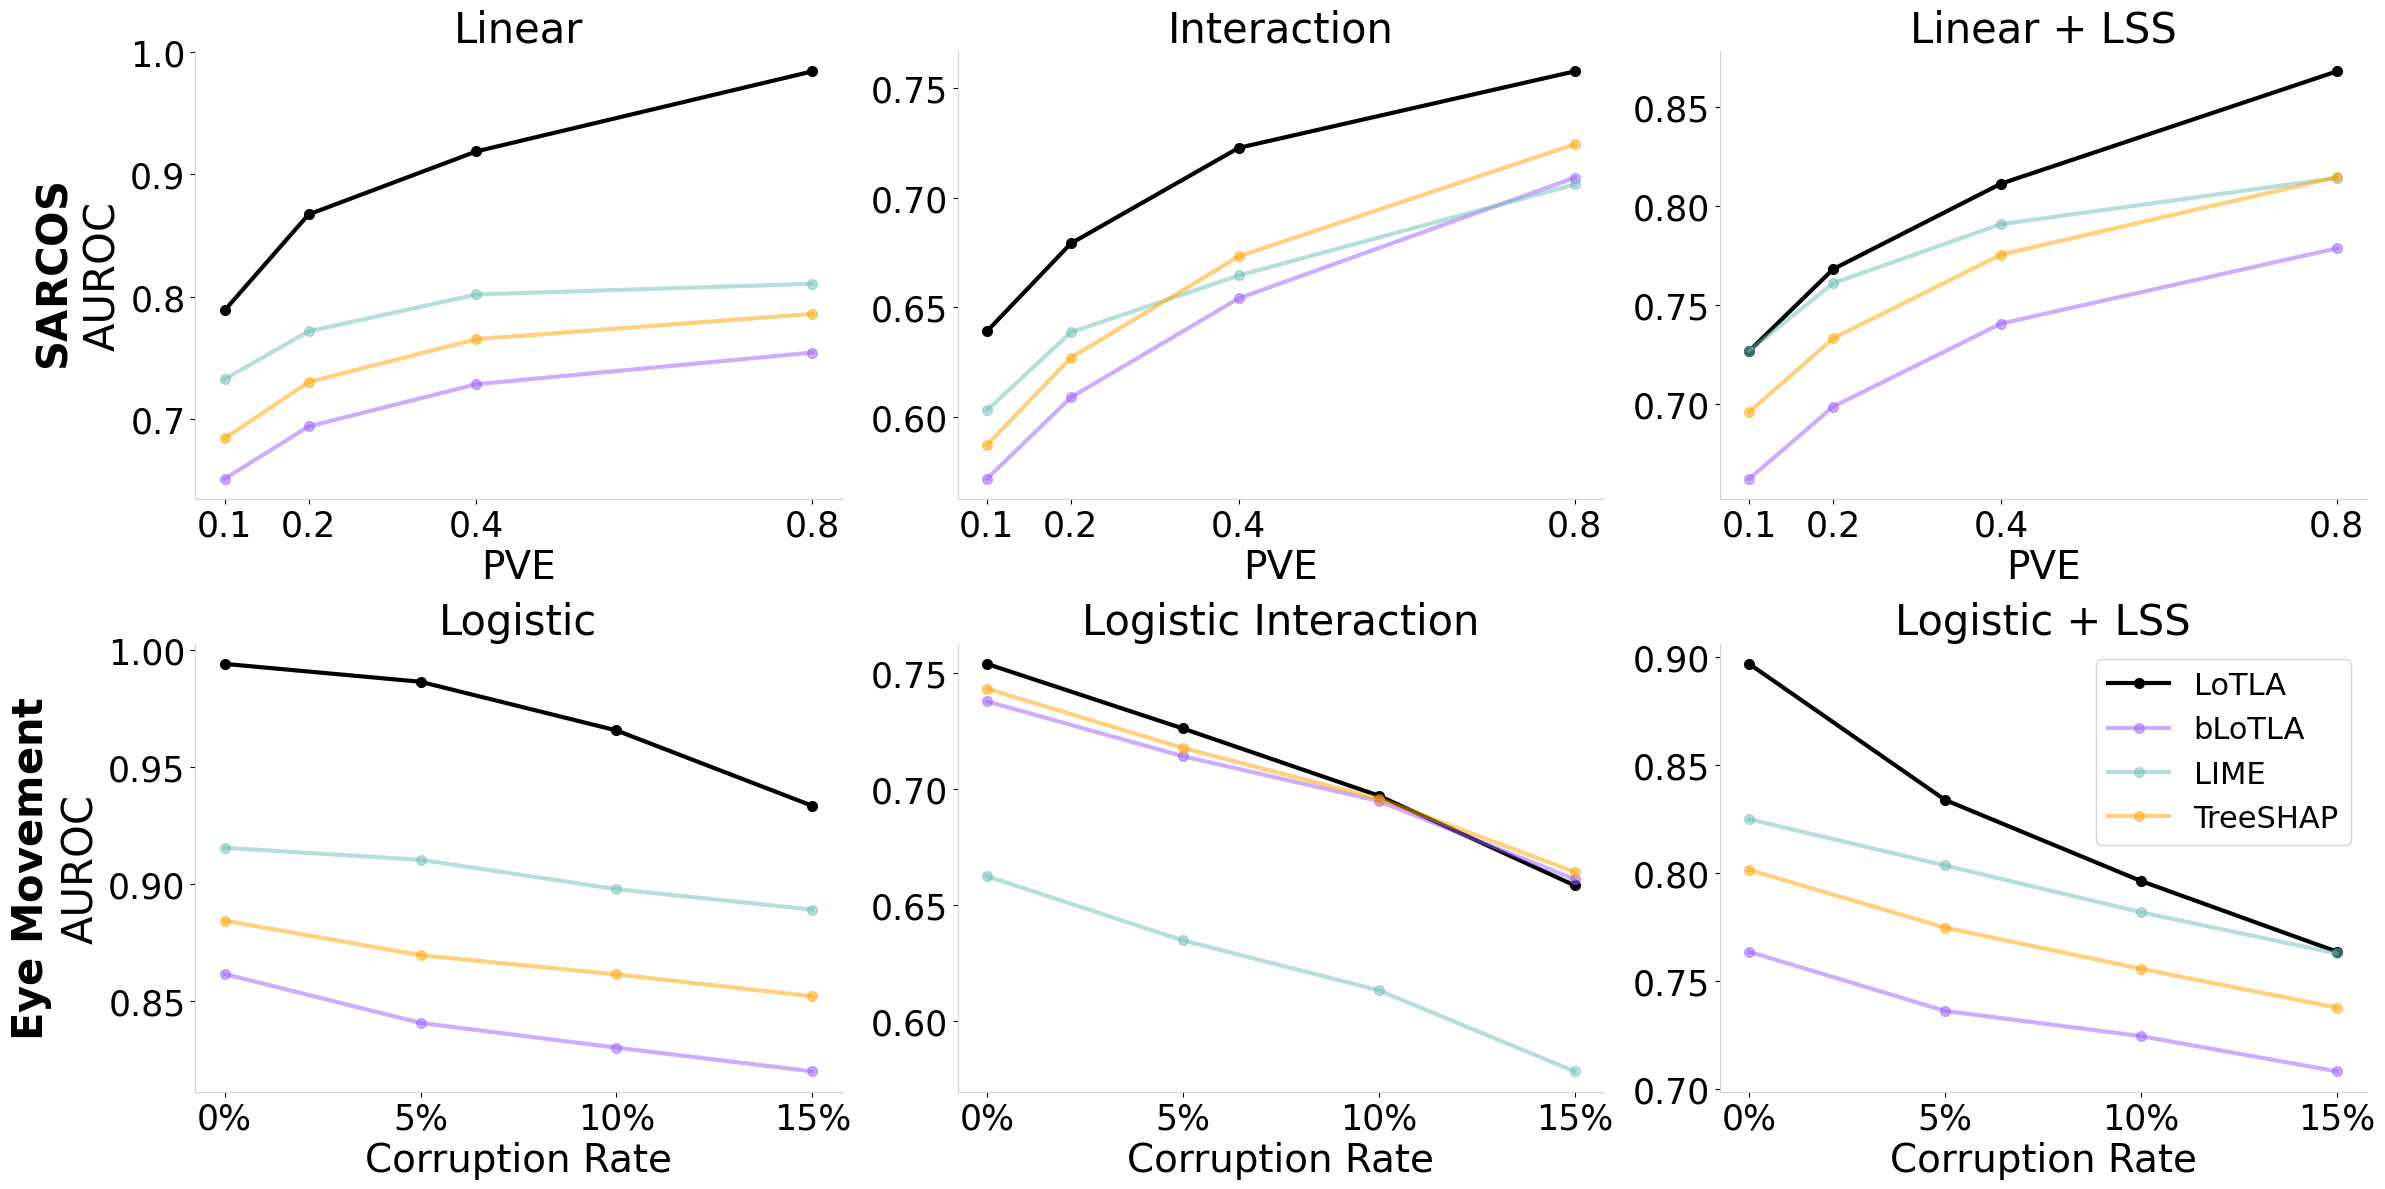

In [6]:
regression_datasets = df_regression["data"].unique()
classification_datasets = df_classification["data"].unique()
regression_dgp = ['linear', 'interaction', 'linear_lss']
classification_dgp = ['logistic_linear', 'logistic_interaction', 'logistic_linear_lss']
marker_size = 7

n_cols = 3
n_rows = 2
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 6 * n_rows),
    sharey=False  # Share y-axis across columns for easier comparison
)

# Ensure axs is 2D for consistent indexing
if n_rows == 1:
    axs = np.expand_dims(axs, axis=0)
if n_cols == 1:
    axs = np.expand_dims(axs, axis=1)

# Plot regression rows
for row_idx, dataset in enumerate(regression_datasets):
    for col_idx, data_generator in enumerate(regression_dgp):
        ax = axs[row_idx, col_idx]
        subset = df_regression[(df_regression["data"] == dataset) & (df_regression["dgp"] == data_generator)]
        
        for method in methods:
            method_data = subset[subset["fi"] == method]
            ax.plot(
                method_data["heritability"], method_data['auroc_test'],
                linestyle='solid', marker='o', markersize=marker_size,
                label=methods_name[method], color=color_map[method],
                linewidth=3, alpha=0.5 if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI'] else 1.0
            )
        ax.set_xticks([0.1, 0.2, 0.4, 0.8])
        ax.set_xticklabels(["0.1", "0.2", "0.4", "0.8"], fontsize=25)
        ax.tick_params(axis='y', labelsize=25)
        ax.set_xlabel("PVE", fontsize=28)
        if col_idx == 0:
            dataset_label = regression_data_name[dataset].replace(' ', r'\ ')
            ax.set_ylabel(f"$\\mathbf{{{dataset_label}}}$\nAUROC", fontsize=30)
        if row_idx == 0:
            ax.set_title(f"{data_generator_label_map[data_generator]}", fontsize=30)
        # if col_idx == n_cols - 1:
        #     ax.legend(fontsize=22, loc='lower right')

# Plot classification rows
for row_idx, dataset in enumerate(classification_datasets, start=len(regression_datasets)):
    for col_idx, data_generator in enumerate(classification_dgp):
        ax = axs[row_idx, col_idx]
        subset = df_classification[(df_classification["data"] == dataset) & (df_classification["dgp"] == data_generator)]
        
        for method in methods:
            method_data = subset[subset["fi"] == method]
            ax.plot(
                method_data["frac_label_corruption"], method_data['auroc_test'],
                linestyle='solid', marker='o', markersize=marker_size,
                label=methods_name[method], color=color_map[method],
                linewidth=3, alpha=0.5 if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI'] else 1.0
            )
        ax.set_xticks([0, 0.05, 0.1, 0.15])
        ax.set_xticklabels(["0%", "5%", "10%", "15%"], fontsize=25)
        ax.tick_params(axis='y', labelsize=25)
        ax.set_xlabel("Corruption Rate", fontsize=28)
        if col_idx == 0:
            dataset_label = classification_data_name[dataset].replace(' ', r'\ ')
            ax.set_ylabel(f"$\\mathbf{{{dataset_label}}}$\nAUROC", fontsize=30)
        if row_idx == len(regression_datasets):
            ax.set_title(f"{data_generator_label_map[data_generator]}", fontsize=30)
        if col_idx == n_cols - 1:
            ax.legend(fontsize=22, loc='upper right')

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("main_paper_feature_ranking_vary_pve.png")
plt.show()


In [5]:
####################################3 * 2 plots############################################
# regression_datasets = df_regression["data"].unique()
# classification_datasets = df_classification["data"].unique()
# regression_dgp = ['linear', 'interaction', 'linear_lss']
# classification_dgp = ['logistic_linear', 'logistic_interaction', 'logistic_linear_lss']
# marker_size = 7


# n_cols = 2  # Now 2 columns
# n_rows = 3  # Now 3 rows
# fig, axs = plt.subplots(
#     nrows=n_rows,
#     ncols=n_cols,
#     figsize=(8 * n_cols, 6 * n_rows),
#     sharey=False  # Share y-axis across columns for easier comparison
# )

# # Ensure axs is 2D for consistent indexing
# if n_rows == 1:
#     axs = np.expand_dims(axs, axis=0)
# if n_cols == 1:
#     axs = np.expand_dims(axs, axis=1)

# # Plot regression rows
# for col_idx, dataset in enumerate(regression_datasets):  # Switch column and row roles
#     for row_idx, data_generator in enumerate(regression_dgp):  # Transpose indexing
#         ax = axs[row_idx, col_idx]
#         subset = df_regression[(df_regression["data"] == dataset) & (df_regression["dgp"] == data_generator)]
        
#         for method in methods:
#             method_data = subset[subset["fi"] == method]
#             ax.plot(
#                 method_data["heritability"], method_data['auroc_test'],
#                 linestyle='solid', marker='o', markersize=marker_size,
#                 label=methods_name[method], color=color_map[method],
#                 linewidth=3, alpha=0.5 if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI'] else 1.0
#             )
#         ax.set_xticks([0.1, 0.2, 0.4, 0.8])
#         ax.set_xticklabels(["0.1", "0.2", "0.4", "0.8"], fontsize=25)
#         ax.tick_params(axis='y', labelsize=25)
#         ax.set_xlabel("PVE", fontsize=28)
#         label = data_generator_label_map[data_generator].replace(' ', '\\ ')
#         ax.set_ylabel(f"$\\bf{{{label}}}$\nAUROC", fontsize=30)
#         if col_idx == 0 and row_idx == 0:
#             dataset_label = regression_data_name[dataset].replace(' ', r'\ ')
#             ax.set_title(f"$\\mathbf{{{dataset_label}}}$", fontsize=30)
#         # if row_idx == n_rows - 1:
#         ax.legend(fontsize=22, loc='lower right')

# # Plot classification rows
# for col_idx, dataset in enumerate(classification_datasets, start=len(regression_datasets)):  # Switch indexing
#     for row_idx, data_generator in enumerate(classification_dgp):  # Transpose indexing
#         ax = axs[row_idx, col_idx]
#         subset = df_classification[(df_classification["data"] == dataset) & (df_classification["dgp"] == data_generator)]
        
#         for method in methods:
#             method_data = subset[subset["fi"] == method]
#             ax.plot(
#                 method_data["frac_label_corruption"], method_data['auroc_test'],
#                 linestyle='solid', marker='o', markersize=marker_size,
#                 label=methods_name[method], color=color_map[method],
#                 linewidth=3, alpha=0.5 if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI'] else 1.0
#             )
#         ax.set_xticks([0, 0.05, 0.1, 0.15])
#         ax.set_xticklabels(["0%", "5%", "10%", "15%"], fontsize=25)
#         ax.tick_params(axis='y', labelsize=25)
#         ax.set_xlabel("Corruption Rate", fontsize=28)
#         label = data_generator_label_map[data_generator].replace(' ', '\\ ')
#         ax.set_ylabel(f"$\\bf{{{label}}}$\nAUROC", fontsize=30)

#         # if col_idx == len(regression_datasets):
#         #     ax.set_title(f"{data_generator_label_map[data_generator]}", fontsize=30)
#         if col_idx == len(regression_datasets) and row_idx == 0:
#             dataset_label = classification_data_name[dataset].replace(' ', r'\ ')
#             ax.set_title(f"$\\mathbf{{{dataset_label}}}$", fontsize=30)
#         # if row_idx == n_rows - 1:
#         ax.legend(fontsize=22, loc='lower right')

# # Adjust layout and spacing
# plt.tight_layout(rect=[0, 0, 1, 1])
# plt.savefig("main_paper_feature_ranking_vary_pve.png")
# plt.show()


In [7]:
combined_df = pd.DataFrame()
datasets = ["openml_361254"]
for dgp in ["linear", "interaction", "linear_lss"]:
    for data in datasets:
        ablation_directory = f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_regression_{data}_{dgp}/{data}_{dgp}_vary_sample_size/varying_heritability_sample_row_n"
        feature_seeds = [1,2,3,4,5]
        error_seed = 1
        sample_seeds = [1,2,3,4,5,6]
        for sample_seed in sample_seeds:
            for feature_seed in feature_seeds:
                df = pd.read_csv(os.path.join(ablation_directory, f"seed_{error_seed}_{feature_seed}_{sample_seed}/results.csv"))
                df["data"] = data
                df["dgp"] = dgp
                combined_df = pd.concat([combined_df, df], ignore_index=True)
df_regression = combined_df.groupby(['sample_row_n', 'heritability', 'dgp', 'fi', 'data'])[["auroc_train", "auroc_test"]].mean().reset_index()

combined_df = pd.DataFrame()
datasets = ["openml_361070"]
for dgp in ["logistic_linear", "logistic_interaction", "logistic_linear_lss"]:
    for data in datasets:
        ablation_directory = f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_classification_{data}_{dgp}/{data}_{dgp}_vary_sample_size/varying_frac_label_corruption_sample_row_n"
        feature_seeds = [1,2,3,4,5]
        error_seed = 1
        sample_seeds = [1,2,3,4,5,6]
        for sample_seed in sample_seeds:
            for feature_seed in feature_seeds:
                df = pd.read_csv(os.path.join(ablation_directory, f"seed_{error_seed}_{feature_seed}_{sample_seed}/results.csv"))
                df["data"] = data
                df["dgp"] = dgp
                combined_df = pd.concat([combined_df, df], ignore_index=True)
df_classification = combined_df.groupby(['sample_row_n', 'frac_label_corruption', 'dgp', 'fi', 'data'])[["auroc_train", "auroc_test"]].mean().reset_index()

In [8]:
df_regression = df_regression[df_regression["heritability"] == 0.4]
df_classification = df_classification[df_classification["frac_label_corruption"] == 0.05]

In [9]:
###################################################### 3 * 2 plots ########################################################
# regression_datasets = df_regression["data"].unique()
# classification_datasets = df_classification["data"].unique()
# regression_dgp = ['linear', 'interaction', 'linear_lss']
# classification_dgp = ['logistic_linear', 'logistic_interaction', 'logistic_linear_lss']
# marker_size = 7
# n_cols = 2  # Now 2 columns
# n_rows = 3  # Now 3 rows
# fig, axs = plt.subplots(
#     nrows=n_rows,
#     ncols=n_cols,
#     figsize=(8 * n_cols, 6 * n_rows),
#     sharey=False  # Share y-axis across columns for easier comparison
# )

# # Ensure axs is 2D for consistent indexing
# if n_rows == 1:
#     axs = np.expand_dims(axs, axis=0)
# if n_cols == 1:
#     axs = np.expand_dims(axs, axis=1)

# # Plot regression rows
# for col_idx, dataset in enumerate(regression_datasets):  # Switch column and row roles
#     for row_idx, data_generator in enumerate(regression_dgp):  # Adjust indexing
#         ax = axs[row_idx, col_idx]
#         subset = df_regression[(df_regression["data"] == dataset) & (df_regression["dgp"] == data_generator)]
        
#         for method in methods:
#             method_data = subset[subset["fi"] == method]
#             ax.plot(
#                 method_data["sample_row_n"], method_data['auroc_test'],
#                 linestyle='solid', marker='o', markersize=marker_size,
#                 label=methods_name[method], color=color_map[method],
#                 linewidth=3, alpha=0.5 if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI'] else 1.0
#             )
#         ax.set_xticks([150, 300, 500])
#         ax.set_xticklabels(["150", "300", "500"], fontsize=25)
#         ax.tick_params(axis='y', labelsize=25)
#         ax.set_xlabel("Sample Size", fontsize=28)
#         label = data_generator_label_map[data_generator].replace(' ', '\\ ')
#         ax.set_ylabel(f"$\\bf{{{label}}}$\nAUROC", fontsize=30)

#         # if col_idx == len(regression_datasets):
#         #     ax.set_title(f"{data_generator_label_map[data_generator]}", fontsize=30)
#         if col_idx == 0 and row_idx == 0:
#             dataset_label = regression_data_name[dataset].replace(' ', r'\ ')
#             ax.set_title(f"$\\mathbf{{{dataset_label}}}$", fontsize=30)
#         # if row_idx == n_rows - 1:
#         ax.legend(fontsize=22, loc='lower right')


# # Plot classification rows
# for col_idx, dataset in enumerate(classification_datasets, start=len(regression_datasets)):  # Switch indexing
#     for row_idx, data_generator in enumerate(classification_dgp):  # Adjust indexing
#         ax = axs[row_idx, col_idx]
#         subset = df_classification[(df_classification["data"] == dataset) & (df_classification["dgp"] == data_generator)]
        
#         for method in methods:
#             method_data = subset[subset["fi"] == method]
#             ax.plot(
#                 method_data["sample_row_n"], method_data['auroc_test'],
#                 linestyle='solid', marker='o', markersize=marker_size,
#                 label=methods_name[method], color=color_map[method],
#                 linewidth=3, alpha=0.5 if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI'] else 1.0
#             )
#         ax.set_xticks([150, 300, 500])
#         ax.set_xticklabels(["150", "300", "500"], fontsize=25)
#         ax.tick_params(axis='y', labelsize=25)
#         ax.set_xlabel("Sample Size", fontsize=28)
#         label = data_generator_label_map[data_generator].replace(' ', '\\ ')
#         ax.set_ylabel(f"$\\bf{{{label}}}$\nAUROC", fontsize=30)

#         # if col_idx == len(regression_datasets):
#         #     ax.set_title(f"{data_generator_label_map[data_generator]}", fontsize=30)
#         if col_idx == len(regression_datasets) and row_idx == 0:
#             dataset_label = classification_data_name[dataset].replace(' ', r'\ ')
#             ax.set_title(f"$\\mathbf{{{dataset_label}}}$", fontsize=30)
#         # if row_idx == n_rows - 1:
#         ax.legend(fontsize=22, loc='lower right')


# # Adjust layout and spacing
# plt.tight_layout(rect=[0.01, 0, 1, 1])
# plt.savefig("main_paper_feature_ranking_vary_sample_size.png")
# plt.show()



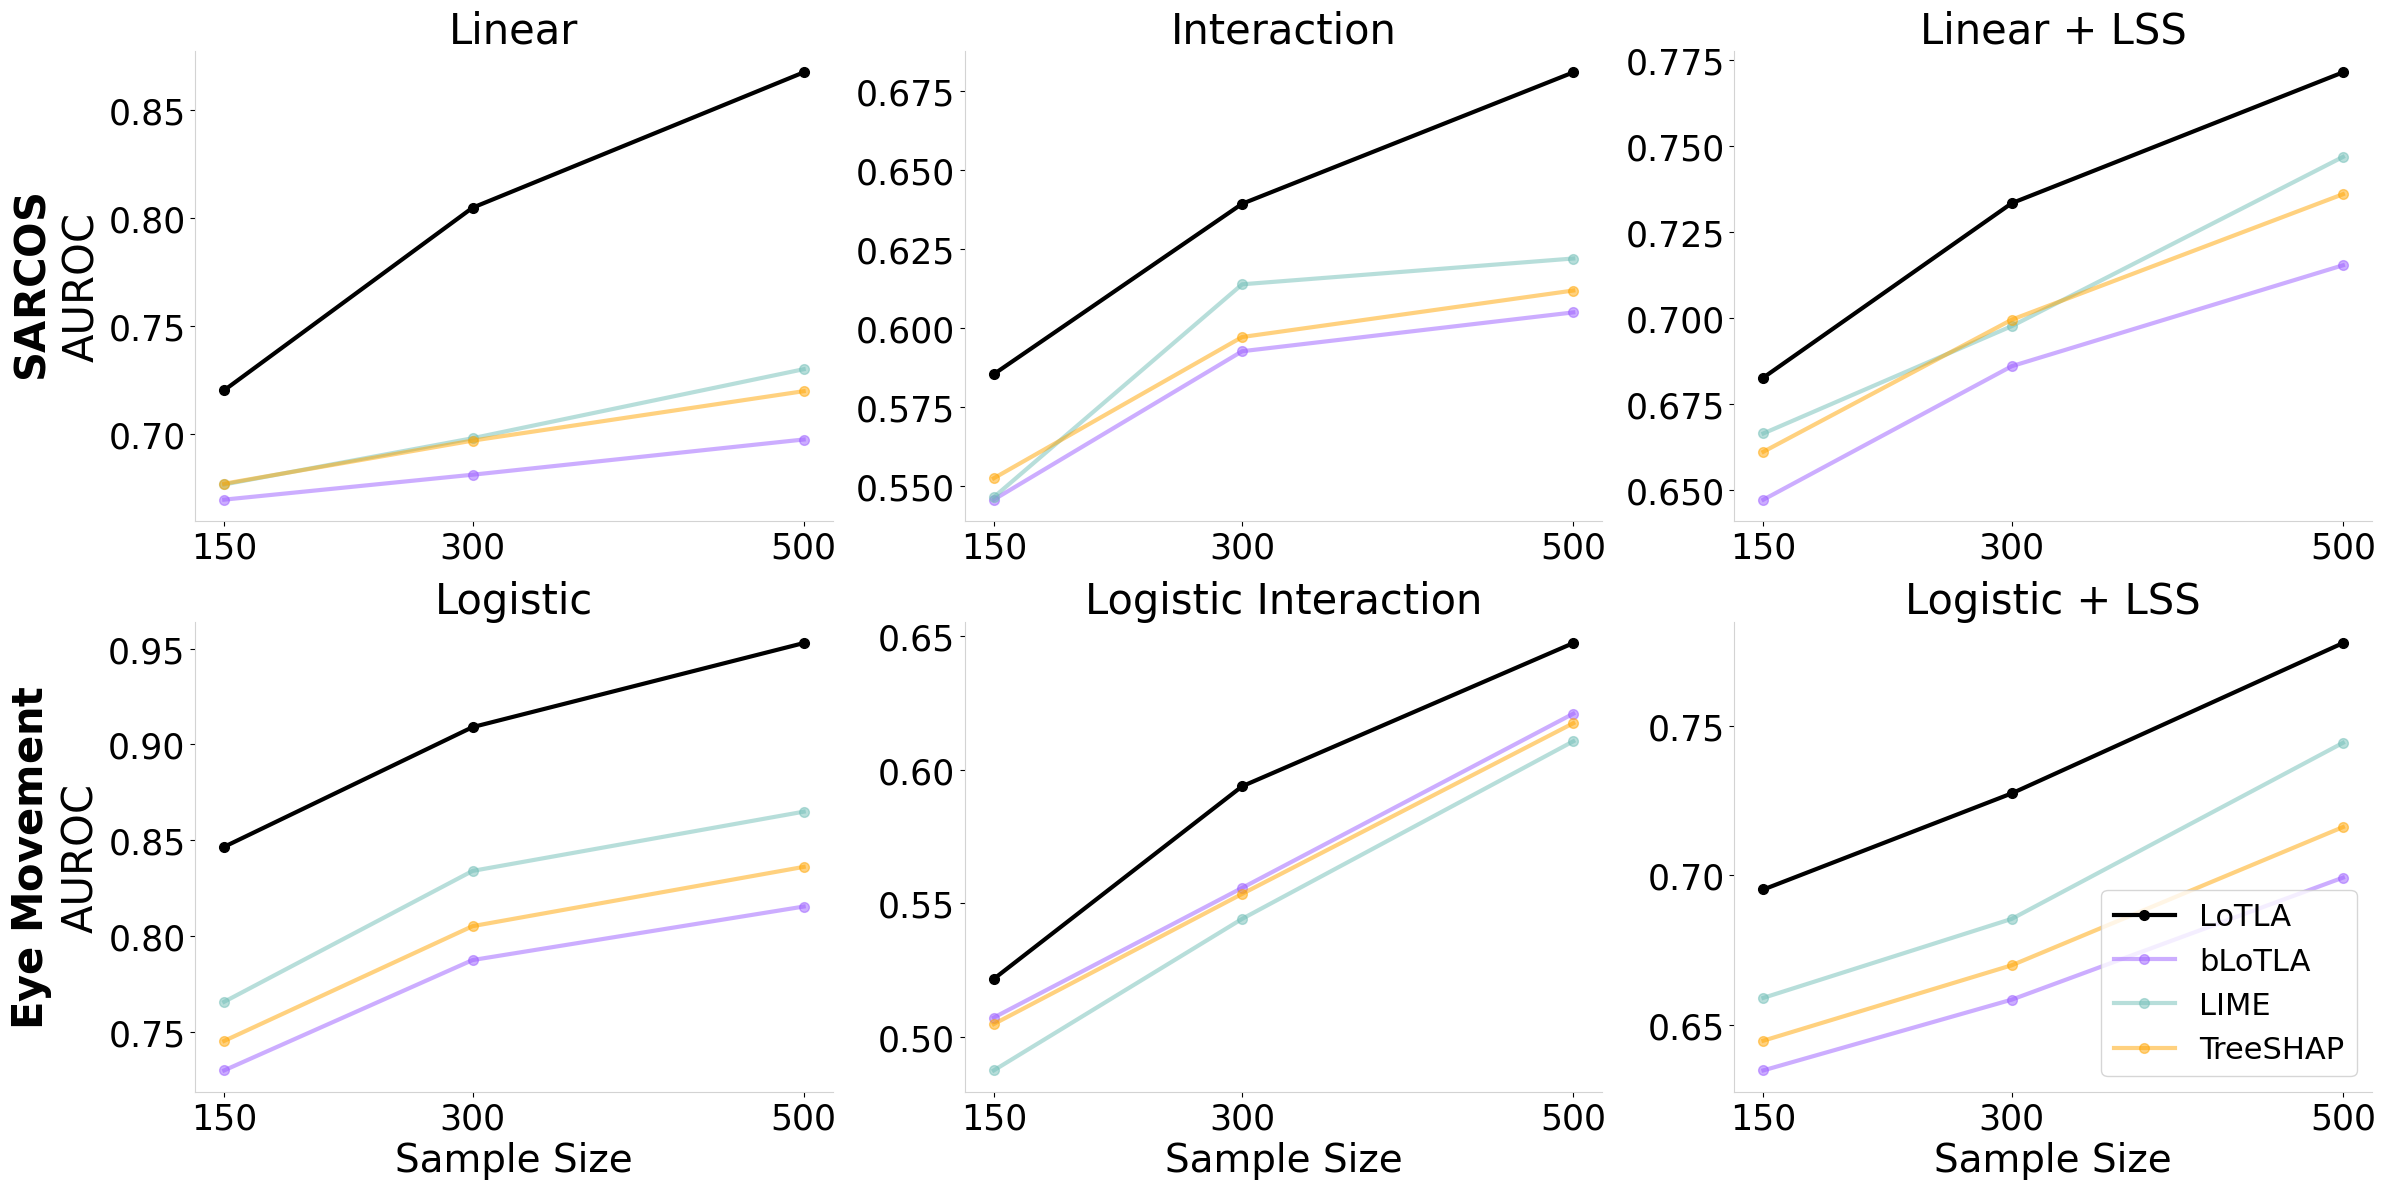

In [10]:
regression_datasets = df_regression["data"].unique()
classification_datasets = df_classification["data"].unique()
regression_dgp = ['linear', 'interaction', 'linear_lss']
classification_dgp = ['logistic_linear', 'logistic_interaction', 'logistic_linear_lss']
marker_size = 7

n_cols = 3
n_rows = 2
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 6 * n_rows),
    sharey=False  # Share y-axis across columns for easier comparison
)

# Ensure axs is 2D for consistent indexing
if n_rows == 1:
    axs = np.expand_dims(axs, axis=0)
if n_cols == 1:
    axs = np.expand_dims(axs, axis=1)

# Plot regression rows
for row_idx, dataset in enumerate(regression_datasets):
    for col_idx, data_generator in enumerate(regression_dgp):
        ax = axs[row_idx, col_idx]
        subset = df_regression[(df_regression["data"] == dataset) & (df_regression["dgp"] == data_generator)]
        
        for method in methods:
            method_data = subset[subset["fi"] == method]
            ax.plot(
                method_data["sample_row_n"], method_data['auroc_test'],
                linestyle='solid', marker='o', markersize=marker_size,
                label=methods_name[method], color=color_map[method],
                linewidth=3, alpha=0.5 if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI'] else 1.0
            )
        ax.set_xticks([150, 300, 500])
        ax.set_xticklabels(["150", "300", "500"], fontsize=25)
        ax.tick_params(axis='y', labelsize=25)
        # ax.set_xlabel("Sample Size", fontsize=25)
        if col_idx == 0:
            dataset_label = regression_data_name[dataset].replace(' ', r'\ ')
            ax.set_ylabel(f"$\\mathbf{{{dataset_label}}}$\nAUROC", fontsize=30)
        if row_idx == 0:
            ax.set_title(f"{data_generator_label_map[data_generator]}", fontsize=30)
        # if col_idx == n_cols - 1:
        #     ax.legend(fontsize=22, loc='lower right')

# Plot classification rows
for row_idx, dataset in enumerate(classification_datasets, start=len(regression_datasets)):
    for col_idx, data_generator in enumerate(classification_dgp):
        ax = axs[row_idx, col_idx]
        subset = df_classification[(df_classification["data"] == dataset) & (df_classification["dgp"] == data_generator)]
        
        for method in methods:
            method_data = subset[subset["fi"] == method]
            ax.plot(
                method_data["sample_row_n"], method_data['auroc_test'],
                linestyle='solid', marker='o', markersize=marker_size,
                label=methods_name[method], color=color_map[method],
                linewidth=3, alpha=0.5 if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI'] else 1.0
            )
        ax.set_xticks([150, 300, 500])
        ax.set_xticklabels(["150", "300", "500"], fontsize=25)
        ax.tick_params(axis='y', labelsize=25)
        ax.set_xlabel("Sample Size", fontsize=28)
        if col_idx == 0:
            dataset_label = classification_data_name[dataset].replace(' ', r'\ ')
            ax.set_ylabel(f"$\\mathbf{{{dataset_label}}}$\nAUROC", fontsize=30)
        if row_idx == len(regression_datasets):
            ax.set_title(f"{data_generator_label_map[data_generator]}", fontsize=30)
        if col_idx == n_cols - 1 and row_idx == n_rows - 1:
            ax.legend(fontsize=22, loc='lower right')

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("main_paper_feature_ranking_vary_sample_size.png")
plt.show()


### Stability

In [11]:
task = "regression" 
combined_df = pd.DataFrame()
datasets = ["openml_361254"]
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_stability/varying_sample_row_n"
    split_seeds = [1,2,3]
    sample_seeds = [1,2,3]
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)
df_regression = combined_df.groupby(['sample_row_n', 'fi', 'data'])[["avg_10_features_all", "avg_20_features_all", "avg_30_features_all", "avg_40_features_all"]].mean().reset_index()

task = "classification" 
datasets = ["openml_361070"]
combined_df = pd.DataFrame()
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_stability/varying_sample_row_n"
    split_seeds = [1,2,3]
    sample_seeds = [1,2,3]
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)
df_classification = combined_df.groupby(['sample_row_n', 'fi', 'data'])[["avg_10_features_all", "avg_20_features_all", "avg_30_features_all", "avg_40_features_all"]].mean().reset_index()


In [12]:
df = pd.concat([df_regression, df_classification], ignore_index=True)
data_name = {
    "openml_361260": "Miami Housing",
    "openml_361622": "Cars",
    "openml_361254": "SARCOS",
    "openml_361259": "Puma Robot",
    "openml_361253": "Wave Energy",
    "openml_361242": "Super Conductivitity",
    "openml_43": "Spam",
    "openml_9946": "Breast Cancer",
    "openml_9978": "Ozone",
    "openml_146819": "Climate",
    "openml_361062": "Pol",
    "openml_361070": "Eye Movement"
}

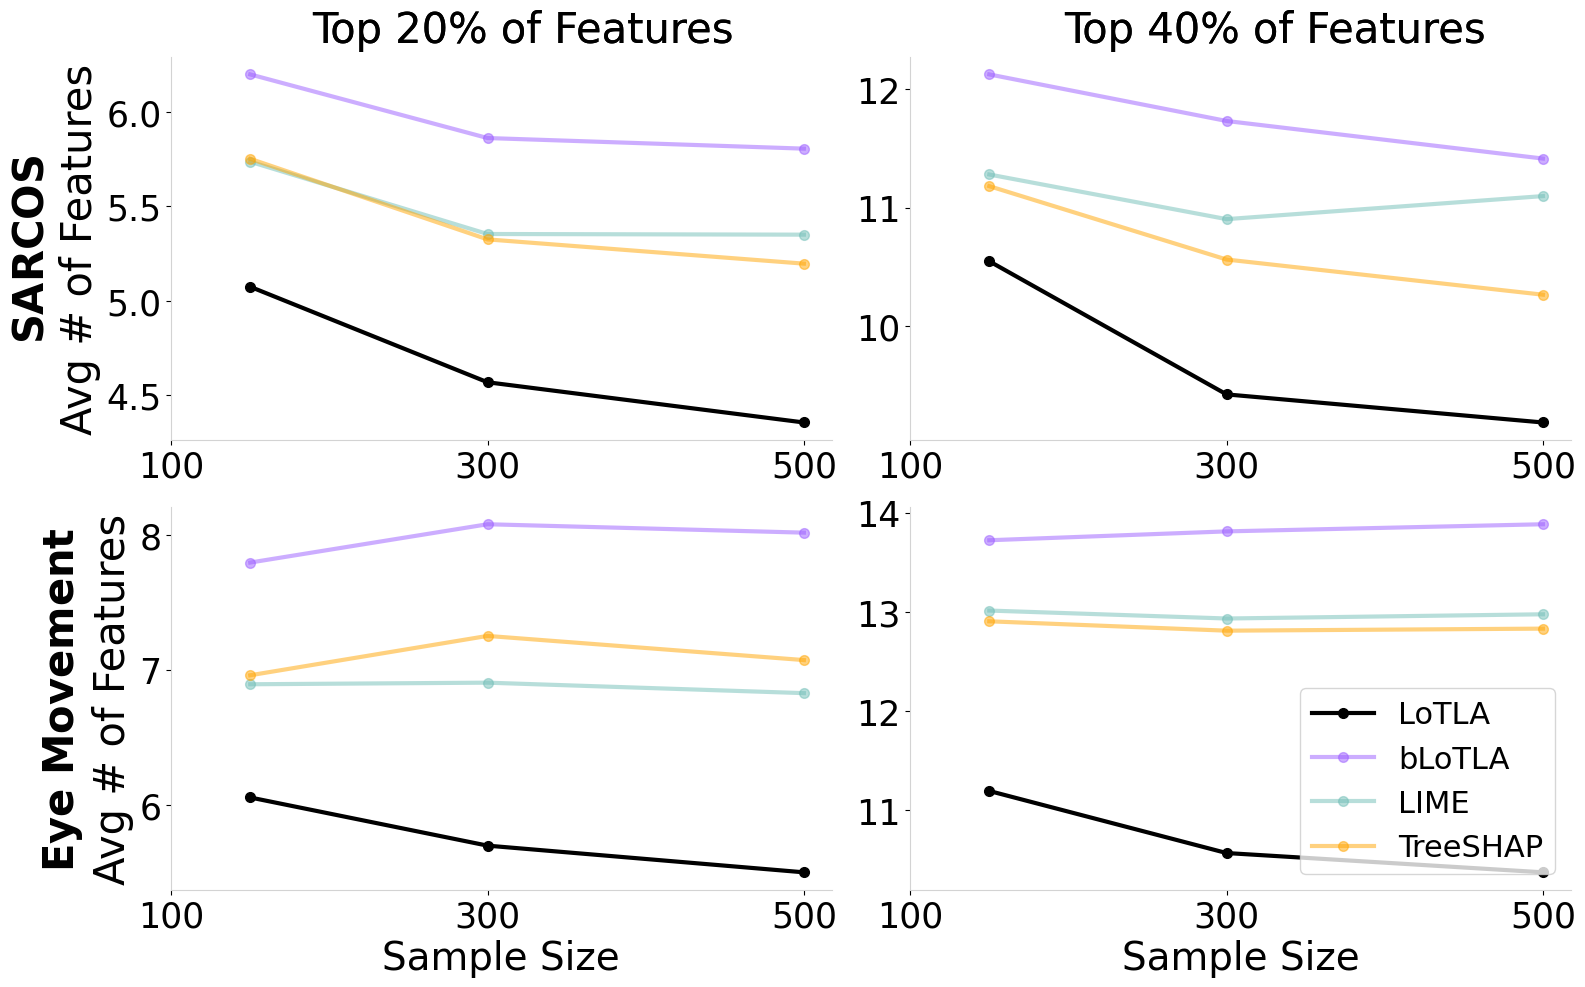

In [13]:
datasets = df["data"].unique()
features_ratio_all = ["avg_20_features_all", "avg_40_features_all"]
marker_size = 7

# Number of columns is fixed (4 for PVE), number of rows is based on the number of datasets
n_cols = len(features_ratio_all)  # One column per PVE
n_rows = len(datasets)          # One row per dataset

# Create subplots
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 5 * n_rows),
    sharey=False  # Share y-axis across columns for easier comparison
)

# Ensure axs is 2D for easy indexing
if n_rows == 1:
    axs = np.expand_dims(axs, axis=0)
if n_cols == 1:
    axs = np.expand_dims(axs, axis=1)

# Loop through each dataset (row) and PVE (column)
for row_idx, dataset in enumerate(datasets):
    for col_idx, features_ratio in enumerate(features_ratio_all):
        ax = axs[row_idx, col_idx]
        subset = df[(df["data"] == dataset)]
        
        # Plot results for each method
        for method in methods:
            method_data = subset[subset["fi"] == method]
            
            if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI']:
                ax.plot(
                    [150,300,500], method_data[features_ratio].values,
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=3, alpha=0.5
                )
            else:
                ax.plot(
                    [150,300,500], method_data[features_ratio].values, 
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=3
                )
        
        # Set x-axis labels and ticks
        ax.set_xticks([100,300,500])
        ax.set_xticklabels(["100", "300", "500"], fontsize=25)
        ax.tick_params(axis='y', labelsize=25)
        if row_idx == n_rows - 1:  # Label x-axis only for the last row
            ax.set_xlabel("Sample Size", fontsize=28)
        
        # Set y-axis labels only for the first column
        if col_idx == 0:
            dataset_label = data_name[dataset].replace(' ', r'\ ')
            ax.set_ylabel(f"$\\mathbf{{{dataset_label}}}$\nAvg # of Features", fontsize=30)
        else:
            ax.set_ylabel("")
        
        # set this for the first row
        if row_idx == 0:
            fig.text(0.33, 0.95, "Top 20% of Features", fontsize=30, ha='center')
            fig.text(0.80, 0.95, "Top 40% of Features", fontsize=30, ha='center')

        # Add legend to the last subplot of the row
        if col_idx == n_cols - 1 and row_idx == n_rows - 1:
            ax.legend(fontsize=22, loc='lower right')

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("main_paper_stability.png")
plt.show()

### Feature Selection

In [14]:
# task = "regression" 
# combined_df = pd.DataFrame()
# datasets = ["openml_361254"]
# for data in datasets:
#     ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection_vary_sample_size/varying_sample_row_n"
#     split_seeds = [1,2,3,4]
#     rf_seed = 1
#     sample_seeds = [1,2,3,4,5]
#     for split_seed in split_seeds:
#         for sample_seed in sample_seeds:
#             df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{rf_seed}_{sample_seed}/results.csv"))
#             df["data"] = data
#             combined_df = pd.concat([combined_df, df], ignore_index=True)
# df_regression = combined_df.groupby(['sample_row_n', 'fi', 'data'])[["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]].mean().reset_index()            

# task = "classification" 
# combined_df = pd.DataFrame()
# datasets = ["openml_9978"]
# for data in datasets:
#     ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection_vary_sample_size/varying_sample_row_n"
#     split_seeds = [1,2,3,4]
#     rf_seed = 1
#     sample_seeds = [1,2,3,4,5]
#     for split_seed in split_seeds:
#         for sample_seed in sample_seeds:
#             df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{rf_seed}_{sample_seed}/results.csv"))
#             df["data"] = data
#             combined_df = pd.concat([combined_df, df], ignore_index=True)
# df_classification = combined_df.groupby(['sample_row_n', 'fi', 'data'])[["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4"]].mean().reset_index()    

In [15]:
# regression_datasets = df_regression["data"].unique()
# classification_datasets = df_classification["data"].unique()
# sample_size_all = [150,300,500]
# marker_size = 7

# n_cols = 3
# n_rows = 2
# fig, axs = plt.subplots(
#     nrows=n_rows,
#     ncols=n_cols,
#     figsize=(8 * n_cols, 6 * n_rows),
#     sharey=False  # Share y-axis across columns for easier comparison
# )

# # Ensure axs is 2D for consistent indexing
# if n_rows == 1:
#     axs = np.expand_dims(axs, axis=0)
# if n_cols == 1:
#     axs = np.expand_dims(axs, axis=1)

# # Plot regression rows
# for row_idx, dataset in enumerate(regression_datasets):
#     for col_idx, sample_size in enumerate(sample_size_all):
#         ax = axs[row_idx, col_idx]
#         subset = df_regression[(df_regression["data"] == dataset) & (df_regression["sample_row_n"] == sample_size)]
        
#         for method in methods:
#             method_data = subset[subset["fi"] == method]
#             ax.plot(
#                 [0.1, 0.2, 0.3, 0.4], method_data[["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]].values[0],
#                 linestyle='solid', marker='o', markersize=marker_size,
#                 label=methods_name[method], color=color_map[method],
#                 linewidth=3, alpha=0.5 if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI'] else 1.0
#             )
#         ax.set_xticks([0.1, 0.2, 0.3, 0.4])
#         ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=22)
#         ax.tick_params(axis='y', labelsize=22)
#         if row_idx == n_rows - 1:  # Label x-axis only for the last row
#             ax.set_xlabel("Percentage of Features Selected", fontsize=25)
#         # ax.set_xlabel("Sample Size", fontsize=25)
#         if col_idx == 0:
#             dataset_label = regression_data_name[dataset].replace(' ', r'\ ')
#             ax.set_ylabel(f"$\\mathbf{{{dataset_label}}}$\n$R^2$", fontsize=30)
#         if row_idx == 0:
#             ax.set_title(rf"$N = {sample_size}$", fontsize=30)
#         if col_idx == n_cols - 1:
#             ax.legend(fontsize=22, loc='lower right')

# # Plot classification rows
# for row_idx, dataset in enumerate(classification_datasets, start=len(regression_datasets)):
#     for col_idx, sample_size in enumerate(sample_size_all):
#         ax = axs[row_idx, col_idx]
#         subset = df_classification[(df_classification["data"] == dataset) & (df_classification["sample_row_n"] == sample_size)]
        
#         for method in methods:
#             method_data = subset[subset["fi"] == method]
#             ax.plot(
#                 [0.1, 0.2, 0.3, 0.4], method_data[["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4"]].values[0], 
#                 linestyle='solid', marker='o', markersize=marker_size,
#                 label=methods_name[method], color=color_map[method],
#                 linewidth=3, alpha=0.5 if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI'] else 1.0
#             )
#         ax.set_xticks([0.1, 0.2, 0.3, 0.4])
#         ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=22)
#         ax.tick_params(axis='y', labelsize=22)
#         if row_idx == n_rows - 1:  # Label x-axis only for the last row
#             ax.set_xlabel("Percentage of Features Selected", fontsize=25)
#         if col_idx == 0:
#             dataset_label = classification_data_name[dataset].replace(' ', r'\ ')
#             ax.set_ylabel(f"$\\mathbf{{{dataset_label}}}$\nAUROC", fontsize=30)
#         # if row_idx == len(regression_datasets):
#         #     ax.set_title(rf"$N = {sample_size}$", fontsize=30)
#         if col_idx == n_cols - 1:
#             ax.legend(fontsize=22, loc='lower right')

# # Adjust layout and spacing
# plt.tight_layout(rect=[0.01, 0, 1, 1])
# plt.savefig("main_paper_feature_selection_vary_sample_size.png")
# plt.show()


In [16]:
# task = "regression" 
# combined_df = pd.DataFrame()
# datasets = ["openml_361254"]
# for data in datasets:
#     ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
#     split_seeds = [1,2,3,4,5]
#     rf_seeds = [1,2,3]
#     for split_seed in split_seeds:
#         for rf_seed in rf_seeds:
#             df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{rf_seed}/results.csv"))
#             df["data"] = data
#             combined_df = pd.concat([combined_df, df], ignore_index=True)
# df_regression = combined_df.groupby(['data','fi'])[["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]].mean().reset_index()

# task = "classification" 
# datasets = ["openml_9978"]
# combined_df = pd.DataFrame()
# for data in datasets:
#     ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
#     split_seeds = [1,2,3,4,5]
#     rf_seeds = [1,2,3]
#     for split_seed in split_seeds:
#         for rf_seed in rf_seeds:
#             df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{rf_seed}/results.csv"))
#             df["data"] = data
#             combined_df = pd.concat([combined_df, df], ignore_index=True)
# df_classification = combined_df.groupby(['data','fi'])[["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4"]].mean().reset_index()

In [17]:
# regression_datasets = df_regression["data"].unique()
# classification_datasets = df_classification["data"].unique()
# marker_size = 7

# n_cols = 4
# n_rows = 1
# fig, axs = plt.subplots(
#     nrows=n_rows,
#     ncols=n_cols,
#     figsize=(8 * n_cols, 6 * n_rows),
#     sharey=False  # Share y-axis across columns for easier comparison
# )

# # Ensure axs is 2D for consistent indexing
# if n_rows == 1:
#     axs = np.expand_dims(axs, axis=0)
# if n_cols == 1:
#     axs = np.expand_dims(axs, axis=1)

# # Plot regression rows
# for col_idx, dataset in enumerate(regression_datasets):
#     ax = axs[0, col_idx]
#     subset = df_regression[(df_regression["data"] == dataset)]
    
#     for method in methods:
#         method_data = subset[subset["fi"] == method]
#         ax.plot(
#             [0.1, 0.2, 0.3, 0.4], method_data[["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]].values[0],
#             linestyle='solid', marker='o', markersize=marker_size,
#             label=methods_name[method], color=color_map[method],
#             linewidth=3, alpha=0.5 if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI'] else 1.0
#         )
#     ax.set_xticks([0.1, 0.2, 0.3, 0.4])
#     ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=25)
#     ax.tick_params(axis='y', labelsize=25)
#     ax.set_xlabel("Percentage of Features Selected", fontsize=28)
#     dataset_label = regression_data_name[dataset].replace(' ', r'\ ')
#     if col_idx == 0:
#         ax.set_ylabel(f"$R^2$", fontsize=30)
#     ax.set_title(f"$\\mathbf{{{dataset_label}}}$", fontsize=30)
#     if col_idx == n_cols - 1:
#         ax.legend(fontsize=22, loc='lower right')

# # Plot classification rows
# for col_idx, dataset in enumerate(classification_datasets, start=len(regression_datasets)):
#     ax = axs[0, col_idx]
#     subset = df_classification[(df_classification["data"] == dataset)]
    
#     for method in methods:
#         method_data = subset[subset["fi"] == method]
#         ax.plot(
#             [0.1, 0.2, 0.3, 0.4], method_data[["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4"]].values[0], 
#             linestyle='solid', marker='o', markersize=marker_size,
#             label=methods_name[method], color=color_map[method],
#             linewidth=3, alpha=0.5 if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI'] else 1.0
#         )
#     ax.set_xticks([0.1, 0.2, 0.3, 0.4])
#     ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=25)
#     ax.tick_params(axis='y', labelsize=25)
#     ax.set_xlabel("Percentage of Features Selected", fontsize=28)
#     dataset_label = classification_data_name[dataset].replace(' ', r'\ ')
#     if col_idx == len(regression_datasets):
#         ax.set_ylabel(f"AUROC", fontsize=30)
#     ax.set_title(f"$\\mathbf{{{dataset_label}}}$", fontsize=30)
#     # if row_idx == len(regression_datasets):
#     #     ax.set_title(rf"$N = {sample_size}$", fontsize=30)
#     if col_idx == n_cols - 1:
#         ax.legend(fontsize=22, loc='lower right')

# fig.text(0.27, 0.92, "Regression", fontsize=35, fontweight="bold", ha="center")
# fig.text(0.77, 0.92, "Classification", fontsize=35, fontweight="bold", ha="center")
# plt.tight_layout(rect=[0, 0, 1, 0.9])
# plt.savefig("main_paper_feature_selection.png")
# plt.show()

In [18]:
task = "regression" 
combined_df = pd.DataFrame()
datasets = ["openml_361254"]
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection_vary_sample_size/varying_sample_row_n"
    split_seeds = [1,2,3,4]
    rf_seed = 1
    sample_seeds = [1,2,3,4,5]
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{rf_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)
combined_df = combined_df[combined_df["sample_row_n"] == 500]
df_regression_500 = combined_df.groupby(['sample_row_n', 'fi', 'data'])[["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]].mean().reset_index()            

task = "classification" 
combined_df = pd.DataFrame()
datasets = ["openml_9978"]
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection_vary_sample_size/varying_sample_row_n"
    split_seeds = [1,2,3,4]
    rf_seed = 1
    sample_seeds = [1,2,3,4,5]
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{rf_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)
combined_df = combined_df[combined_df["sample_row_n"] == 500]
df_classification_500 = combined_df.groupby(['sample_row_n', 'fi', 'data'])[["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4"]].mean().reset_index()    

In [19]:
task = "regression" 
combined_df = pd.DataFrame()
datasets = ["openml_361254"]
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
    split_seeds = [1,2,3,4,5]
    rf_seeds = [1,2,3]
    for split_seed in split_seeds:
        for rf_seed in rf_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{rf_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)
df_regression_all = combined_df.groupby(['data','fi'])[["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]].mean().reset_index()
df_regression_all["sample_row_n"] = 48933

task = "classification" 
datasets = ["openml_9978"]
combined_df = pd.DataFrame()
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
    split_seeds = [1,2,3,4,5]
    rf_seeds = [1,2,3]
    for split_seed in split_seeds:
        for rf_seed in rf_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{rf_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)
df_classification_all = combined_df.groupby(['data','fi'])[["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4"]].mean().reset_index()
df_classification_all["sample_row_n"] = 2534

In [20]:
# concatenate 
df_regression = pd.concat([df_regression_500, df_regression_all], ignore_index=True)
df_classification = pd.concat([df_classification_500, df_classification_all], ignore_index=True)

In [21]:
df_regression

,sample_row_n,fi,data,RF_Regressor_R2_top_0.1,RF_Regressor_R2_top_0.2,RF_Regressor_R2_top_0.3,RF_Regressor_R2_top_0.4
0,500,LIME_RF,openml_361254,0.722306,0.810626,0.820937,0.820329
1,500,Local_MDI+_MDI_elasticnet_fit_on_all_ranking_R...,openml_361254,0.837783,0.833210,0.831617,0.827946
2,500,MDI,openml_361254,0.688943,0.811415,0.821608,0.819295
3,500,TreeSHAP_RF,openml_361254,0.722343,0.810436,0.821616,0.819029
4,48933,LIME_RF,openml_361254,0.875117,0.957255,0.964612,0.969711
5,48933,Local_MDI+_MDI_elasticnet_fit_on_all_ranking_R...,openml_361254,0.944036,0.958145,0.965048,0.968616
6,48933,MDI,openml_361254,0.869230,0.957253,0.964132,0.968932
7,48933,TreeSHAP_RF,openml_361254,0.869250,0.957246,0.964488,0.969272


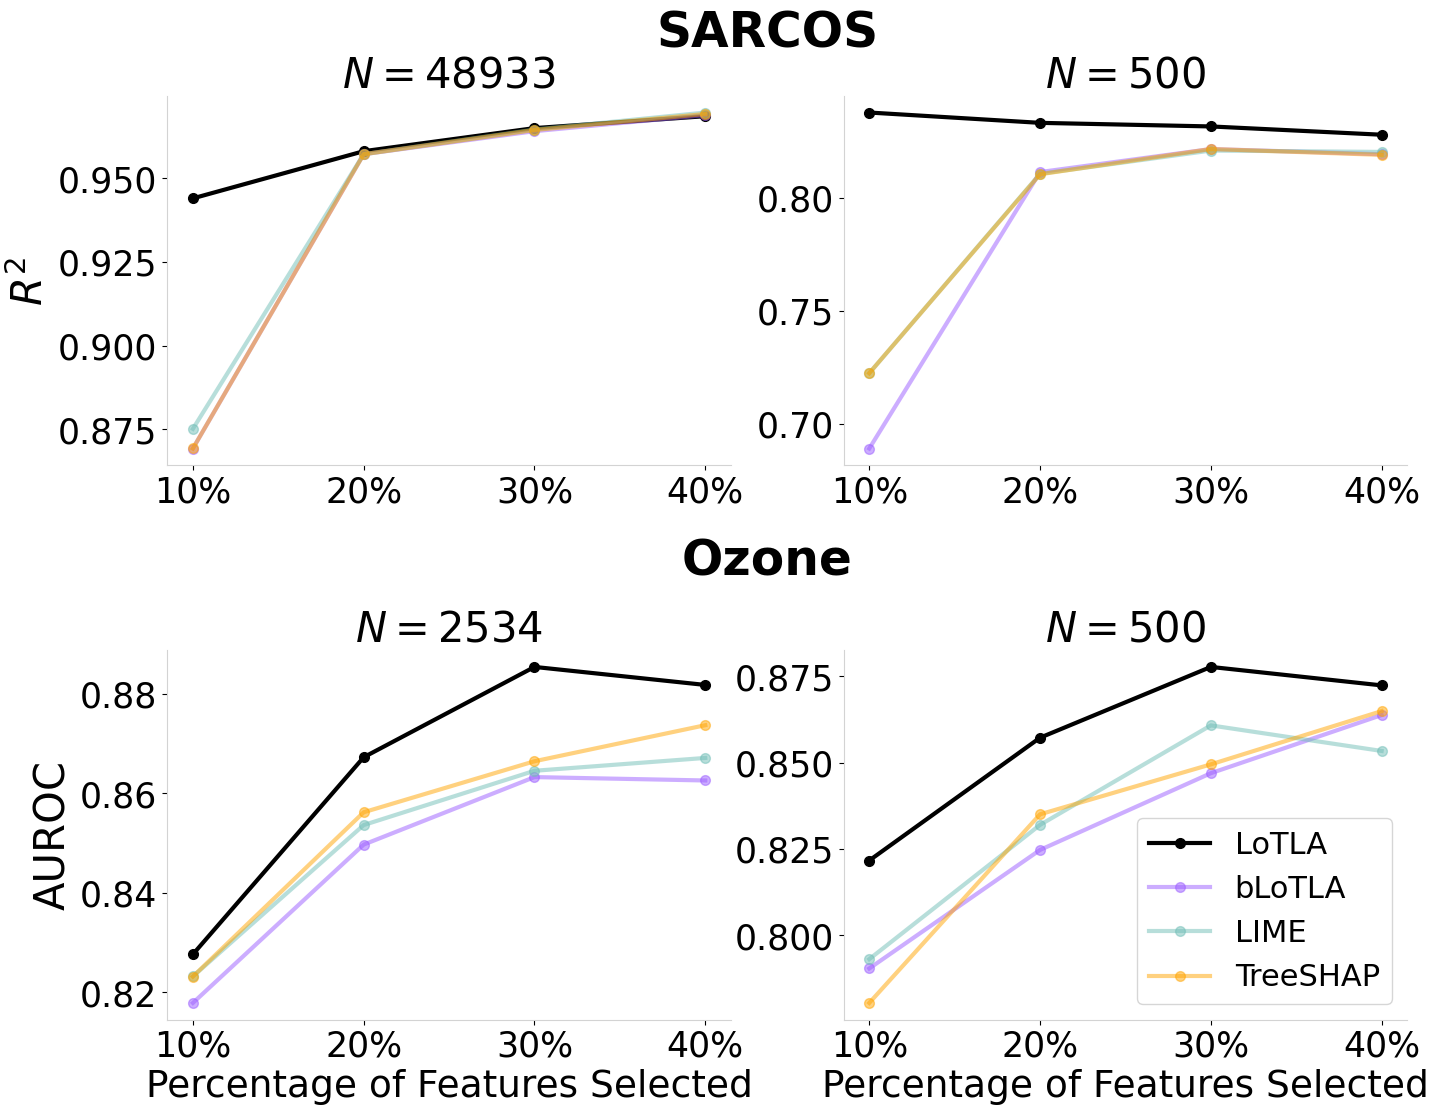

In [22]:
regression_datasets = df_regression["data"].unique()
sample_size_all_regression = df_regression["sample_row_n"].unique()[::-1]
classification_datasets = df_classification["data"].unique()
sample_size_all_classification = df_classification["sample_row_n"].unique()[::-1]
marker_size = 7

n_cols = 2
n_rows = 2
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 6 * n_rows),
    gridspec_kw={'hspace': 0.5},
    sharey=False
)

# Ensure axs is 2D for consistent indexing
if n_rows == 1:
    axs = np.expand_dims(axs, axis=0)
if n_cols == 1:
    axs = np.expand_dims(axs, axis=1)

# Plot regression rows
for row_idx, dataset in enumerate(regression_datasets):
    for col_idx, sample_size in enumerate(sample_size_all_regression):
        ax = axs[row_idx, col_idx]
        subset = df_regression[(df_regression["data"] == dataset) & (df_regression["sample_row_n"] == sample_size)]
    
        for method in methods:
            method_data = subset[subset["fi"] == method]
            ax.plot(
                [0.1, 0.2, 0.3, 0.4], method_data[["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]].values[0],
                linestyle='solid', marker='o', markersize=marker_size,
                label=methods_name[method], color=color_map[method],
                linewidth=3, alpha=0.5 if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI'] else 1.0
            )
        ax.set_xticks([0.1, 0.2, 0.3, 0.4])
        ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=25)
        ax.tick_params(axis='y', labelsize=25)
        # ax.set_xlabel("Percentage of Features Selected", fontsize=28)
        dataset_label = regression_data_name[dataset].replace(' ', r'\ ')
        if col_idx == 0:
            ax.set_ylabel(f"$R^2$", fontsize=30)
        # ax.set_title(f"$\\mathbf{{N = {sample_size}}}$", fontsize=30)
        ax.set_title(r"$N = {}$".format(sample_size), fontsize=30) 
        # if col_idx == n_cols - 1:
        #     ax.legend(fontsize=22, loc='lower right')

# Plot classification rows
for row_idx, dataset in enumerate(classification_datasets, start=len(regression_datasets)):
    for col_idx, sample_size in enumerate(sample_size_all_classification):
        ax = axs[row_idx, col_idx]
        subset = df_classification[(df_classification["data"] == dataset) & (df_classification["sample_row_n"] == sample_size)]
    
        for method in methods:
            method_data = subset[subset["fi"] == method]
            ax.plot(
                [0.1, 0.2, 0.3, 0.4], method_data[["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4"]].values[0], 
                linestyle='solid', marker='o', markersize=marker_size,
                label=methods_name[method], color=color_map[method],
                linewidth=3, alpha=0.5 if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI'] else 1.0
            )
        ax.set_xticks([0.1, 0.2, 0.3, 0.4])
        ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=25)
        ax.tick_params(axis='y', labelsize=25)
        ax.set_xlabel("Percentage of Features Selected", fontsize=27)
        dataset_label = classification_data_name[dataset].replace(' ', r'\ ')
        if col_idx == 0:
            ax.set_ylabel(f"AUROC", fontsize=30)
        # ax.set_title(f"$\\mathbf{{N = {sample_size}}}$", fontsize=30)
        ax.set_title(r"$N = {}$".format(sample_size), fontsize=30)
        # if row_idx == len(regression_datasets):
        #     ax.set_title(rf"$N = {sample_size}$", fontsize=30)
        if col_idx == n_cols - 1:
            ax.legend(fontsize=22, loc='lower right')

fig.text(0.5, 0.92, "SARCOS", fontsize=35, fontweight="bold", ha="center")
fig.text(0.5, 0.48, "Ozone", fontsize=35, fontweight="bold", ha="center")
plt.savefig("main_paper_feature_selection.png")
plt.show()